==============================================================================================
# Practicum 6 - Part 2

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P6_Student1_Student2.zip** that includes:
    - The notebook P6_2_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Group A- Group F): December 23th, 23:00 h**

**Deadline (Group B): December 24th, 23:00 h**

==============================================================================================
## Dimensionality reduction and face detection
==============================================================================================

**Problem to solve**: Define a space of image feature that allows to represent objects based on their appearance or a set of local features in the image.

Documentation [Face recognition skimage](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html)

==============================================================================================


Today's exercices will practise the following:

1. Define an appropiate representation (descriptors objects):
    - Normally, reduce size of the data preserving the invariance and removing redundant dimensions.


2. Train a classifier from a set of examples with their descriptors.


3. Recognize a new face example using the learned model.

## Imports

In [1]:
from time import time

import numpy as np
from numpy import unique
import matplotlib.pyplot as plt


In [31]:
def visualize_n(image_list):

    fig=plt.figure(figsize=(15,15))
    for i in range(len(image_list)):
        
        fig.add_subplot(1,len(image_list),i +1)
        plt.imshow(image_list[i], cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
def visualize_n_w_labels(image_list, labels):

    fig=plt.figure(figsize=(15,15))
    for i in range(len(image_list)):
        
        fig.add_subplot(1,len(image_list),i +1)
        plt.imshow(image_list[i], cmap='gray')
        plt.title(labels[i])
        plt.xticks([])
        plt.yticks([])
        
def normalize(image): return (image[:,:]- image.min())/(image.max() - image.min())

## Principal Component Analysis (PCA)

### Dimensionality and redundancy

Imagine we have a dataset with 100x100 pixel images, it means we have 10000 dimensions. We want to construct a low-dimensional linear subspace that best explains the variation in the set of face images (**Eigenfaces space**)

<img src="notebook_images/subspace.PNG" width=200, height=200>

Each image has m rows and n columns and defines a vector of (mxn) elements. We need to choose the most valuable pixels in order to avoid compute all dimensions. 

<img src="notebook_images/feature_vector.PNG" width=800, height=400>

We look for a transformation of the original space to a smaller (M << (mxn)) where faces are represented with their coordinates in this new space R.

To reduce the dimensionality retaining the information necessary to classify and recognize, we are going to use the **Eigenfaces method** 

### How to build a reduced space?

To build this new space, we are going to use the **Principal Component Analysis**. Given a large space, the PCA looks for the minimum number of axes that best represents the variation of the data.

<img src="notebook_images/pca.PNG" width=400, height=400>

The eigenvectors of the covariance matrix define the axis of maximum variance and the eigenvalues give a measure of the variance of the data. 

1. Construct the vector in the (m x n)-dimensional space R given M images of size (m x n).

2. Compute the mean image 

<center>
$\overline{X}=\frac{1}{M}\sum_{i=1}^{M} X_i$
</center>

3. Construct the covariance matrix. Due to $A \times A^T$ is too large, instead of using $A \times A^T$ to compute its eigenvectors, we are going to compute the eigenvectors of $A^T \times A$.

<img src="notebook_images/covariance_image.PNG" width=500, height=500>

4. Extract the eigenvectors (the base of the new space) and their eigenvalues and project faces in the new space to apply the classifier (knn)


### 1. Load and prepare data

Let's use the [Labeled Faces in the Wild (LFW)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html) people dataset (classification).

Face dataset features:

- Classes: 5749

- Samples total: 13233

- Dimensionality: 5828

- Features: real, between 0 and 255


*sklearn.datasets.fetch_lfw_people(data_home=None, funneled=True, resize=0.5, min_faces_per_person=0, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)*



*Please, check the parameters and returned value by ``lethc_lfw_people()`` before continuing.*

**1.1** Load the dataset.

Obtain only those cases where there are, at least, 100 images. Check the final number of images, image shapes and labels of the images.

In [74]:
# Load the dataset
from sklearn.datasets import fetch_lfw_people 

dataset = fetch_lfw_people(data_home=None, funneled=True, resize=0.5, 
                                                     min_faces_per_person=100, color=False, 
                                                     slice_=(slice(70, 195, None), slice(78, 172, None)), 
                                                     download_if_missing=True, return_X_y=False)

n_samples, height, width = dataset.images.shape

In [75]:
dataset #dictionary with: dades, imatges, target(classes i coses), description (noms)

{'data': array([[ 76.       ,  82.666664 ,  91.333336 , ...,  34.       ,
          31.333334 ,  28.333334 ],
        [ 40.333332 ,  48.666668 ,  82.       , ..., 119.       ,
         210.33333  , 240.66667  ],
        [ 50.666668 ,  63.333332 ,  81.666664 , ..., 252.33333  ,
         251.66667  , 250.33333  ],
        ...,
        [ 73.333336 ,  78.666664 ,  84.333336 , ...,  73.       ,
          57.333332 ,  54.666668 ],
        [102.333336 , 102.333336 , 101.666664 , ..., 235.33333  ,
         230.33333  , 226.33333  ],
        [  1.3333334,   1.6666666,   3.3333333, ...,  64.333336 ,
          33.333332 ,   7.       ]], dtype=float32),
 'images': array([[[ 76.       ,  82.666664 ,  91.333336 , ..., 113.333336 ,
           92.333336 ,  97.333336 ],
         [ 74.666664 ,  84.333336 ,  94.666664 , ..., 111.333336 ,
           94.666664 ,  95.       ],
         [ 79.       ,  90.666664 ,  98.666664 , ..., 114.333336 ,
          101.       ,  99.333336 ],
         ...,
         [ 14.

**1.2** Plot an image frome each example, with its name as the title of the image.

<img src="notebook_images/example.png" width=500, height=500>

(62, 47)

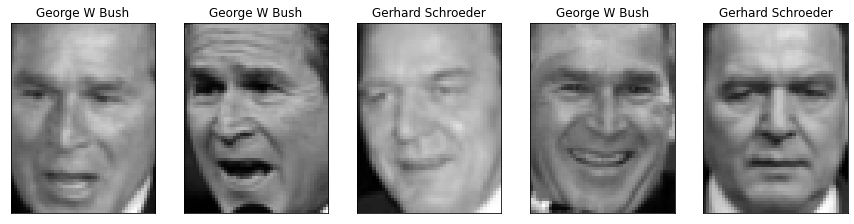

In [76]:
data = dataset.data
labels = dataset['target']
n_features = data.shape[1]


TOTAL_IMAGES = 5
images = dataset['images'][:TOTAL_IMAGES]
name = [dataset['target_names'][i] for i in labels[:TOTAL_IMAGES]]

visualize_n_w_labels(images, name)

**1.3** Divide the dataset into train and test set (0.7/0.3). 

**Hint:** use the train_test_split function.

In [64]:
# Split dataset into training and test
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3)

X_train, X_test, y_train, y_test
X_train.shape

(447, 2914)

### 2. Compute PCA

[*class sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

The principal components measure deviations about this mean along orthogonal axes.


**2.1** Create a PCA object, using the training set and a 150 components

In [128]:
# Principal component analysis
from sklearn.decomposition import PCA

n_comp=150

pca = PCA(n_components=n_comp, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', 
            random_state=None)

vector = pca.fit(X_train, y_train)

print(np.array(vector).shape)

()


Plot the accumated variance of the components. 

**Hint:** Use the returned `explained_variance_ratio_`.

In [112]:
#grafiaca de barres de tots els anteriors. 
np.cumsum(vector.explained_variance_ratio_)

array([0.18581611, 0.34492886, 0.41906515, 0.47576842, 0.52716476,
       0.5598052 , 0.5859675 , 0.610861  , 0.6329595 , 0.6528162 ,
       0.67009425, 0.6856572 , 0.6983842 , 0.71013004, 0.72116286,
       0.7308746 , 0.7399036 , 0.74827564, 0.7560811 , 0.7632716 ,
       0.77012223, 0.7766344 , 0.7828999 , 0.7886193 , 0.79417944,
       0.79939127, 0.8045047 , 0.8095045 , 0.81422806, 0.8186616 ,
       0.82286   , 0.82677764, 0.8305603 , 0.83423525, 0.83777225,
       0.8411815 , 0.8444604 , 0.84756297, 0.8506251 , 0.8535133 ,
       0.85638237, 0.85918665, 0.8618943 , 0.86451375, 0.86704695,
       0.869532  , 0.87191635, 0.8741785 , 0.876401  , 0.8785956 ,
       0.8807005 , 0.8827666 , 0.8847727 , 0.8867361 , 0.88866526,
       0.89054817, 0.8923432 , 0.89409167, 0.8958151 , 0.89749193,
       0.8991268 , 0.9007203 , 0.90227246, 0.903816  , 0.90531653,
       0.90677184, 0.90820974, 0.90961343, 0.9109965 , 0.91235334,
       0.9136727 , 0.9149913 , 0.91627586, 0.9175579 , 0.91878

What is the variable *pca*?

In [ ]:
#explicar després

**2.2** One interesting part of PCA is that it computes the average face, which can be interesting to examine. 

Plot the average face, using the method `mean_` of the PCA object.

**Hint:** The average face need to be reshaped in order to visualize it properly

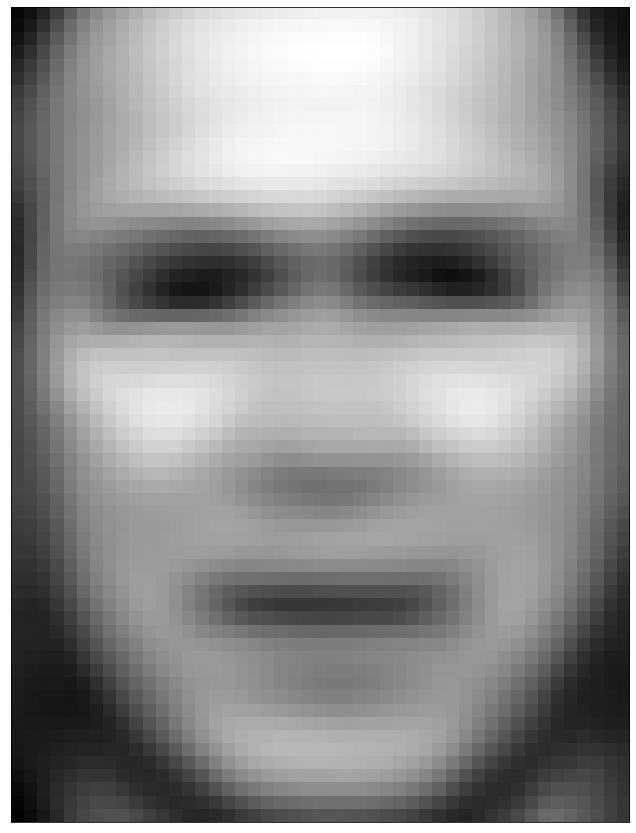

In [79]:
image = vector.mean_.reshape((height, width))

visualize_n([image])

**2.3** Furhtermore, we can check all the principal components (i.e. eigenfaces) considering the corresponding importance.

Visualize 30 principal eigenfaces

<img src="notebook_images/eigenfaces.png" width=500, height=500>

150

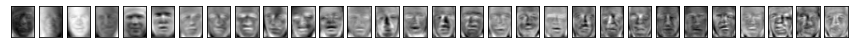

In [104]:
#comentari A=\lambdaV
eigenvectors = [image.reshape((height, width)) for image in vector.components_]

visualize_n(eigenvectors[:30])
len(eigenvectors)

Note that the base components are ordered by their importance. We see that the first few components seem to primarily take care of lighting conditions; the remaining components pull out certain identifying features: the nose, eyes, eyebrows, etc.

**2.4** Project both the training and test set onto the PCA basis, using the method `transform()` of the PCA object.

In [99]:
trans_train = pca.transform(X_train)
trans_test = pca.transform(X_test)

DO you need to apply the same to the variable y?

In [100]:
# no, només reduÏm el npombre de features, no el nombre de samples

**2.5**  These projected components correspond to factors in a linear combination of component images such that the combination approaches the original face. 

Choose one of the images and try to recompose from its first 10 most important corresponding eigenfaces.


<br/>
<img src="notebook_images/eigenfaces_image.PNG" width=300, height=300>


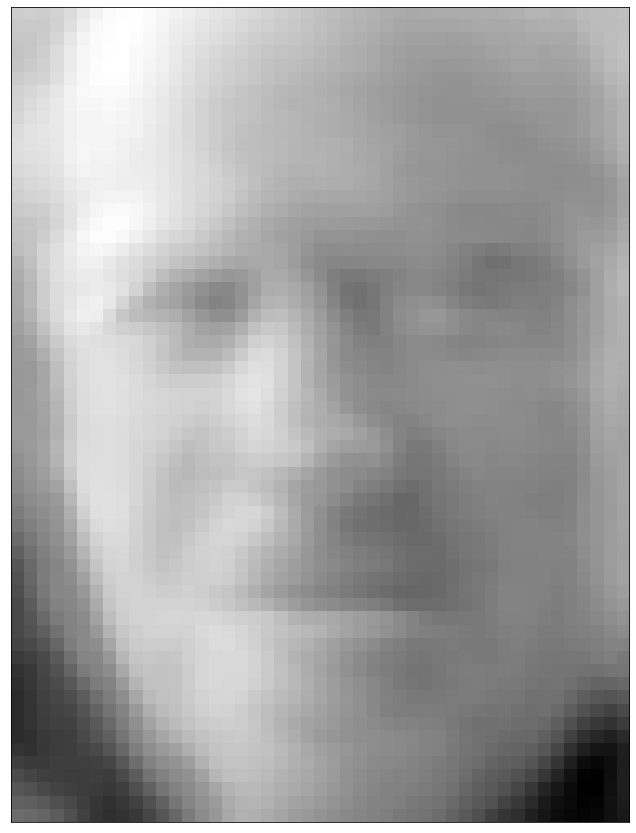

In [111]:
MOST_IMPORTANT = 10

eigenvalues = trans_train[0]

average = np.sum(np.array([eigenvalues[i]*eigenvectors[i] for i in range(0, MOST_IMPORTANT)]),axis=0)

visualize_n([average])

What is the purpose of the PCA tool?

In [ ]:
#redïuir el nombre de features sense pèrdua generalitat per simplificar el problema a un tractable

### 3. Train a classifier

**3.1** Train an Adaboost classifier using the PCA features. Show the results obtained with the test set.
Use the `score` method of the Adaboost model.

In [134]:
# Train a Adaboost classifier
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=n_comp, learning_rate=1.0)

ada.fit(trans_train, y_train)

AdaBoostClassifier(n_estimators=150)

In [136]:
ada.score(trans_test, y_test)

0.9739583333333334

**3.2** We can quantify this effectiveness using one of several measures from sklearn.metrics. First we can do the classification report, which shows the precision, recall and other measures of the “goodness” of the classification.

*sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')*

*Please, check the parameters and returned value by ``classification_report()`` before continuing.*

Print the classification report obtained during the training of the Adaboost model.

In [140]:
# Classification and results
from sklearn.metrics import classification_report 

y_pred = ada.predict(trans_test)

result =classification_report(y_test, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, 
                              output_dict=False, zero_division='warn')
print(result)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       167
           1       0.95      0.84      0.89        25

    accuracy                           0.97       192
   macro avg       0.97      0.92      0.94       192
weighted avg       0.97      0.97      0.97       192



Please, explaing what is:
- accuracy (score)
- precision
- recall
- f1-score
- support
- macro avg
- weighted avg?


In [ ]:
#yes

**3.3** Train an Adaboost classifier, without PCA, using the training set. Show the results using the `score` method of the Adaboost model and the corresponding classification report.

In [141]:
# Train a Adaboost classifier
from sklearn.ensemble import AdaBoostClassifier

ada2 = AdaBoostClassifier(n_estimators=150)
ada2.fit(X_train, y_train)
ada2.score(X_test, y_test)

0.9322916666666666

**Questions**

- Does computing time change using PCA? How?
- Which of both (with and without PCA) does give better results?
- How does the result change if we change the number of components in PCA?
- How does the result change if we change the number of estimators in the Adaboost?

In [ ]:
# Your answer here

**3.5 (Optional)** Repeat the experiment using a different number of components. 

For instance, instead of using 150 components, try using 10, 25, 50, 200, 500... at your election. These numbers are just orientative. 

- How much variance is acummulated using the different number of components.
- The result is better using... how many components? 
- Does time change using a different numbero of components?

In [ ]:
# Your solution here

### 4. Recognize a new face example using the learned model

**4.1** Try your both models using the test set. 

Predict the labels using the Adaboost model, with and without PCA, and plot the images with the corresponding label as title.

<img src="notebook_images/prediction.png" width=300 height = 300>

In [ ]:
# Your solution here

Which model makes the predictions betters? Try different parameters.

In [ ]:
# Your solution here